# Foundations Of AIML
## Session 11
### Experiment 1.3: Learning rates

The objective of this experiment is to tune the hyper parameter called learning rate and observe the changes in the output.

We will use CIFAR100 dataset.This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 50,000 training images and 10,000 testing images.

**Importing required Packages**

In [0]:
cd 2018_04_07_Session11

/content/drive/TempCopies/2018_04_07_Session11


In [0]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [0]:
# Checking for GPU instance
use_cuda = torch.cuda.is_available()
#Intilizaing the accuracy value as zero
best_acc = 0

#### Data Preparation

In [0]:
print('\n[Phase 1] : Data Preparation')

##dataset
dataset = 'cifar100'

# Preparing the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
]) # meanstd transformation


[Phase 1] : Data Preparation


#### Applying the standard mean

In [0]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
])

#### Downloading and Loading the dataset

The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.


In [0]:
# number of classes in the dataset
num_classes = 100

In [0]:
### Downloading the dataset
trainset = torchvision.datasets.CIFAR100(root='/data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='/data', train=False, download=False, transform=transform_test)
### Loading the dataset 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)


Files already downloaded and verified


#### Let us define the network

In [0]:
import torch.nn as nn
import torch.nn.functional as F

        
class LeNet(nn.Module):
    def __init__(self, num_classes, init_mode='xavier'):  ### supports 'zero', 'normal', 'xavier', 'he' inits
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
        
        if init_mode == 'zero':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.zero_()   ### fill tensor elements with zeros
                    if m.bias is not None:
                        m.bias.data.zero_()
        
        if init_mode == 'normal':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.normal_()   ### fill tensor elements with random numbers from normal distribution
                    if m.bias is not None:
                        m.bias.data.normal_()
        
        if init_mode == 'xavier':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                    n = fan_in + fan_out
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in+fan_out))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
        
        if init_mode == 'he':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
                
                
    ## Forward Pass
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return(out)

### Training with Xavier init

In [0]:
## Calling the model
net = LeNet(num_classes, init_mode='xavier')
# Checking for GPU instance
if use_cuda:
    net.cuda()

In [0]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()

In [0]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    #Declaring the variables
    train_loss = 0
    correct = 0
    total = 0
    # Looping over train data
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Checking for GPU instance
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        # Optimizer
        optimizer.zero_grad()
        # Converting targets and inputs into pytorch variables
        #inputs, targets = Variable(inputs), Variable(targets)
        # Forward Pass
        outputs = net(inputs)
        # Storing the outputs size
        size_ = outputs.size()
        # Reducing the dimenssion
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        # backward Pass
        loss.backward()
        # Optimizer Step
        optimizer.step()
        # Calculating the tarining loss
        #train_loss += loss.data[0]
        train_loss += loss.item()
        # Predicting the values
        _, predicted = torch.max(outputs_.data, 1)
        # Storing the targets size
        total += targets.size(0)
        # Calculating the corrected values
        correct += predicted.eq(targets.data).cpu().sum()
        # printing the data
        if batch_idx%30 == 0 or batch_idx == len(trainloader)-1:
            # printing the progress bar
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Storing number of epoch,loss and accuracy in a file    
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [0]:
def test(epoch):
    global best_acc
    # Declaring the valules
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    # Looping over test data
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # Checking for GPU instance
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        # Converting inputs and targets into pytorch variables
        #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        # Forward Pass
        outputs = net(inputs)
        # Storing the outputs size
        size_ = outputs.size()
        # Reducing the dimenssions
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        # Calculating the test loss
        #test_loss += loss.data[0]
        test_loss += loss.item()
        # Storing the predicted values
        _, predicted = torch.max(outputs_.data, 1)
        # Storing the targets size
        total += targets.size(0)
        # Caluculating the correct values
        correct += predicted.eq(targets.data).cpu().sum()
        # Printing the data
        if batch_idx%30 == 0 or batch_idx == len(testloader)-1:
            # Printing the progress bar
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Printing the validation loss
    print('val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total)
    # Storing number of epoch,loss and accuracy in a file
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    # Checking for best accuracy
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net,
            'acc': acc,
            'epoch': epoch,
        }
        # Checking whether its a directory or not
        if not os.path.isdir('../checkpoint'):
            # Creating a directory
            os.mkdir('../checkpoint')
        # Saving the data
        torch.save(state, '../checkpoint_ckpt.t7')
        # Storing the best accuracy
        best_acc = acc

In [0]:
experiment = 'lr_schedule'
# Creating files in write mode
train_loss_file = open("./"+experiment+"train_loss.txt", "w")
val_loss_file = open("./"+experiment+"val_loss.txt", "w")

In [0]:
### Training and testing the model for 60 epochs
for epoch in range(0, 60):
    if epoch == 50:
        optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
    if epoch == 30:
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    if epoch == 0:
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    # Training the model
    train(epoch)
    # Testing the model
    test(epoch)
# Closing the files 
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 4.356 | Acc: 4.000% (2026/50000)  391/391 
 [==================================>] | Loss: 4.004 | Acc: 8.000% (874/10000)   100/100 
val_loss:  4.004079759120941 accuracy:  tensor(8)
Saving..


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Epoch: 1
 [==================================>] | Loss: 3.908 | Acc: 9.000% (4956/50000)  391/391 
 [==================================>] | Loss: 3.725 | Acc: 12.000% (1265/10000) 100/100 
val_loss:  3.725189552307129 accuracy:  tensor(12)
Saving..

Epoch: 2
 [==================================>] | Loss: 3.706 | Acc: 12.000% (6458/50000) 391/391 
 [==================================>] | Loss: 3.563 | Acc: 15.000% (1586/10000) 100/100 
val_loss:  3.5627992939949036 accuracy:  tensor(15)
Saving..

Epoch: 3
 [==================================>] | Loss: 3.565 | Acc: 15.000% (7660/50000) 391/391 
 [==================================>] | Loss: 3.378 | Acc: 18.000% (1892/

#### Plotting the training curves

6 6


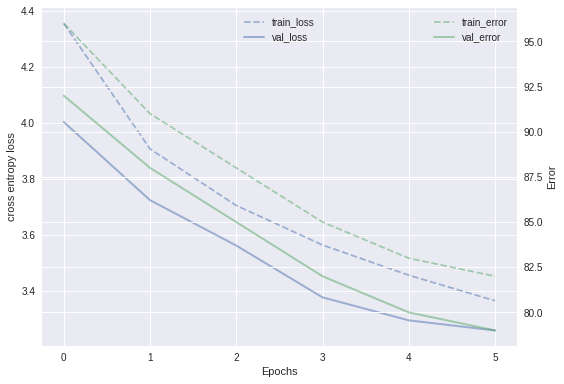

In [0]:
training_curves("./"+experiment)

#### 1. Notice the slope of loss and accuracy for the epoch when learning rate is changed. What could be the reason of this jump?

#### 2. Why do you think it would be better to start with a high learning rate and high momentum and subsequently decrease during the next epochs?